# Extracting the dataset

In [ ]:
from google.colab import files
files.upload()

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 78% 41.0M/52.6M [00:01<00:00, 40.0MB/s]
100% 52.6M/52.6M [00:01<00:00, 50.2MB/s]


In [6]:
!unzip /content/jigsaw-toxic-comment-classification-challenge.zip

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [7]:
!unzip /content/sample_submission.csv.zip
!unzip /content/test.csv.zip
!unzip /content/test_labels.csv.zip
!unzip /content/train.csv.zip

Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  /content/train.csv.zip
  inflating: train.csv               


In [8]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [9]:
train = pd.read_csv("train.csv",index_col = 'id')
test  = pd.read_csv("test.csv")
sub   = pd.read_csv("sample_submission.csv")

print(f"Train Data Dimensions are {train.shape}")
print(f"Test Data Dimensions are {test.shape}")
print(f"Sample Submission Dimensions are {sub.shape}")


Train Data Dimensions are (159571, 7)
Test Data Dimensions are (153164, 2)
Sample Submission Dimensions are (153164, 7)


# Model with LSTM

## Getting Libraries

In [10]:
# ! pip install Cmake
# ! pip install --upgrade gensim
# ! pip install --upgrade language-check

! pip install tqdm
! pip install contractions
# ! pip install pycontractions


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.2 MB/s eta 0:00:00


In [11]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import string
import nltk
import re
import contractions

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer

In [13]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

## Creating the Model

In [14]:
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
print(stopwords)

{'when', 'was', 'under', 'herself', 'd', "wouldn't", 'other', 'more', "won't", 'be', 'an', 'wouldn', 'there', 'own', 'm', 'while', 'yours', 'some', 'll', 'i', 'our', 'whom', 'into', 'me', 'each', 'both', 'haven', 'where', "hasn't", 'is', 'am', 'not', 'can', 'shan', 'above', 'of', 'did', "you've", 'himself', 'hasn', 'mightn', 'through', 'once', 'had', 'about', 'who', 'your', 'will', 'now', 'yourselves', "you'd", 'again', 'needn', 'to', 'hadn', 'how', 'mustn', 'over', 'because', 'than', "hadn't", "doesn't", 'from', 'few', "couldn't", 'that', 'for', "didn't", 'with', 'or', 'o', 't', "don't", 'the', "aren't", 'this', 'myself', 'in', 'doesn', "isn't", "she's", 'aren', 'ourselves', 'by', 'up', "haven't", 'no', 'she', 'during', 'they', "you'll", 'them', "mustn't", 'why', 'don', 's', 'been', 'after', 'his', 'do', 'very', 'weren', 'too', 'before', 'off', 'if', 'same', 'such', 'between', 'should', 'here', 'her', 'y', 'and', 'wasn', "wasn't", "you're", "that'll", 'these', 'then', 'we', 'hers', 't

### Pre-Processing words

In [16]:
""" This function tokenizes the input text into words and removes common stopwords.
 Stopwords are words that are generally considered to be of little value in text analysis since they are very common (e.g., "and", "the", "is").
  The function uses the NLTK library's word_tokenize function for tokenization.
"""
def stopWords_removal(text):
    words = word_tokenize(text)
    words_filtered = [w.lower() for w in words if w.lower() not in stopwords]
    new_text = " ".join(words_filtered)
    return new_text if new_text else ""


"""
This function uses a regular expression to replace sequences of three or more repeated characters
with a single instance of that character. This helps in reducing elongated words.
For example, "sooo" becomes "so."
"""
def redundance_removal(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1", text)


"""
This function incorporates multiple text processing steps:
Removal of URLs using a regular expression.
Stripping of '#' characters.
Expansion of contractions using the contractions library.
Removal of punctuation using string.punctuation.
Removal of non-word characters using a regular expression.
Removal of stopwords using the stopWords_removal function.
Removal of non-English characters by keeping only alphabetical characters.
Removal of the word "user" or "username" (case insensitive) from the text.
Reduction of elongated words using the redundance_removal function.

If any exceptions occur during the processing, it catches them, prints an error message, and returns the original text.
"""
def processing(text):

    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '', text)


    text = stopWords_removal(text)


    text = contractions.fix(text)
    text = re.sub(r"[^a-zA-Z0-9' ]", ' ', text)
    text = re.sub(r' +', ' ', text)

    extract_words = re.compile(r'\W+')
    text = extract_words.sub(' ', text)

    text = re.sub('[^a-zA-Z\s]', '', text)

    text = re.sub(r'user(?:name)?\s', '', text)

    text = redundance_removal(text)

    return text

In [17]:
# Create a model-specific copy of the data

df = train.copy(deep=True)

In [18]:
# Process the dataset along with TQDM to monitor progress
tqdm.pandas(desc="Processing comments", position=0, leave=True)
df['comment_text'] = df['comment_text'].progress_apply(processing)

Processing comments: 100%|██████████| 159571/159571 [02:32<00:00, 1049.59it/s]


In [19]:
df.duplicated().sum()

1255

In [20]:
df.drop_duplicates(inplace = True)

In [21]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,explanation edits made hardcore metallica fan ...,0,0,0,0,0,0
000103f0d9cfb60f,d aww matches background colour m seemingly st...,0,0,0,0,0,0
000113f07ec002fd,hey man m really trying edit war s guy constan...,0,0,0,0,0,0
0001b41b1c6bb37e,ca n t make real suggestions improvement wond...,0,0,0,0,0,0
0001d958c54c6e35,sir hero chance remember page s,0,0,0,0,0,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158316 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   158316 non-null  object
 1   toxic          158316 non-null  int64 
 2   severe_toxic   158316 non-null  int64 
 3   obscene        158316 non-null  int64 
 4   threat         158316 non-null  int64 
 5   insult         158316 non-null  int64 
 6   identity_hate  158316 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment_text'])

In [24]:
import pickle

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
Twords = tokenizer.word_index
# print(Twords)

In [26]:
train_sequences = tokenizer.texts_to_sequences(df['comment_text'])

In [27]:
max_length = max([len(x) for x in train_sequences])
max_length

1348

In [28]:
pad_type = 'post'
trunc_type = 'post'
maxlen = 200

In [29]:
train_padded = pad_sequences(train_sequences, padding=pad_type, maxlen=maxlen)
train_padded

array([[  544,    50,    53, ...,     0,     0,     0],
       [  563, 15143,  2383, ...,     0,     0,     0],
       [  288,   299,    15, ...,     0,     0,     0],
       ...,
       [29489,  6784,  2514, ...,     0,     0,     0],
       [  439,    11,   114, ...,     0,     0,     0],
       [   56,     3,     2, ...,     0,     0,     0]], dtype=int32)

In [30]:
wordMap = {Twords[word]: word for word in Twords.keys()}

In [31]:
def get_original_sequence(text):
  ogText = []
  for sequence in text:
    if sequence in wordMap:
            ogText.append(wordMap[sequence])
    else:
            ogText.append("<UNK>")

  return " ".join(ogText)

In [32]:
get_original_sequence(train_sequences[0])

'explanation edits made hardcore metallica fan reverted n t vandalisms closure gas voted new york dolls fac please n t remove template talk page since m retired now'

In [33]:
# df_label = df.iloc[:, [0] + list(range(2, df.shape[1]))]
df_label = df.iloc[:, 1:]
df_label

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
0000997932d777bf,0,0,0,0,0,0
000103f0d9cfb60f,0,0,0,0,0,0
000113f07ec002fd,0,0,0,0,0,0
0001b41b1c6bb37e,0,0,0,0,0,0
0001d958c54c6e35,0,0,0,0,0,0
...,...,...,...,...,...,...
ffe987279560d7ff,0,0,0,0,0,0
ffea4adeee384e90,0,0,0,0,0,0
ffee36eab5c267c9,0,0,0,0,0,0


In [34]:
x_train, x_temp, y_train, y_temp = train_test_split(train_padded, df_label,
                                                    test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp,
                                                    test_size=0.5, random_state=42)

In [35]:
x_train.shape

(126652, 200)

In [36]:
x_test.shape

(15832, 200)

In [37]:
x_val.shape

(15832, 200)

In [38]:
common_samples = set(map(tuple, x_val)) & set(map(tuple, x_test))


In [39]:
x_test

array([[   171,    107,    805, ...,      0,      0,      0],
       [  5817,   3546,      0, ...,      0,      0,      0],
       [   749,   2240,   1263, ...,      0,      0,      0],
       ...,
       [   551,    386,     50, ...,      0,      0,      0],
       [ 14940, 131707,   1155, ...,      0,      0,      0],
       [ 20381,     14,    105, ...,      0,      0,      0]], dtype=int32)

In [40]:
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')

In [41]:
vSize     = len(Twords)+1
vFeatures = 128

lstm = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vSize, vFeatures),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True, dropout=0.1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True, dropout=0.1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.1)),
    tf.keras.layers.Dense(16, activation= tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='sigmoid')
])


# vSize     = len(Twords)+1
# vFeatures = 128

# lstm_2 = tf.keras.models.Sequential([
#     tf.keras.layers.Embedding(vSize, vFeatures),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(6, activation='sigmoid')
# ])


# vSize     = len(Twords)+1
# vFeatures = 100

# lstm_2 = tf.keras.models.Sequential([
#     tf.keras.layers.Embedding(vSize, vFeatures),
#     tf.keras.layers.LSTM(100,return_sequences=True),
#     tf.keras.layers.LSTM(64,return_sequences=True),
#     tf.keras.layers.LSTM(32),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(32, activation= tf.keras.layers.LeakyReLU(alpha=0.01)),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(6, activation='sigmoid')
# ])

In [42]:
# class CustomCallback(tf.keras.callbacks.Callback):
#     def __init__(self, threshold):
#         super(CustomCallback, self).__init__()
#         self.threshold = threshold

#     def on_epoch_end(self, epoch, logs=None):
#         val_acc = logs["val_accuracy"]
#         if val_acc >= self.threshold:
#             self.model.stop_training = True

In [43]:
checkpoint_filepath1 = '/tmp/checkpoint1'
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True
  )

In [44]:
from tensorflow.keras.metrics import AUC
roc_auc = AUC()

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[roc_auc])


In [45]:
# history = lstm_2.fit(x_train, y_train, epochs=5, batch_size=128,
#                      validation_data=(x_val, y_val),verbose =1 ,
#                      callbacks=[model_checkpoint_callback1])

In [46]:


tf.debugging.disable_traceback_filtering()

In [47]:
history = lstm.fit(x_train, y_train, epochs=5, batch_size=128,validation_data=(x_val, y_val),verbose =1 ,callbacks=[model_checkpoint_callback1])
#history = lstm_2.fit(x_train, y_train, epochs=5, batch_size=128,validation_data=(x_val, y_val),verbose =1 )

Epoch 1/5
990/990 [==============================] - 168s 140ms/step - loss: 0.1084 - auc: 0.8876 - val_loss: 0.0522 - val_auc: 0.9764
Epoch 2/5
990/990 [==============================] - 102s 103ms/step - loss: 0.0503 - auc: 0.9793 - val_loss: 0.0493 - val_auc: 0.9798
Epoch 3/5
990/990 [==============================] - 90s 91ms/step - loss: 0.0424 - auc: 0.9866 - val_loss: 0.0497 - val_auc: 0.9737
Epoch 4/5
990/990 [==============================] - 88s 89ms/step - loss: 0.0371 - auc: 0.9901 - val_loss: 0.0512 - val_auc: 0.9705
Epoch 5/5
990/990 [==============================] - 83s 83ms/step - loss: 0.0333 - auc: 0.9925 - val_loss: 0.0532 - val_auc: 0.9700


In [48]:
lstm.load_weights(checkpoint_filepath1)

In [49]:
# loss, accuracy = lstm.evaluate(test)
# print(f'Test loss: {loss:.4f}')
# print(f'Test accuracy: {accuracy:.4f}')

In [50]:
y_pred = lstm.predict(x_test)

495/495 [==============================] - 12s 20ms/step


In [51]:
y_test_values = y_test.values.flatten()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_values, y_pred.ravel())
roc_auc = auc(fpr, tpr)

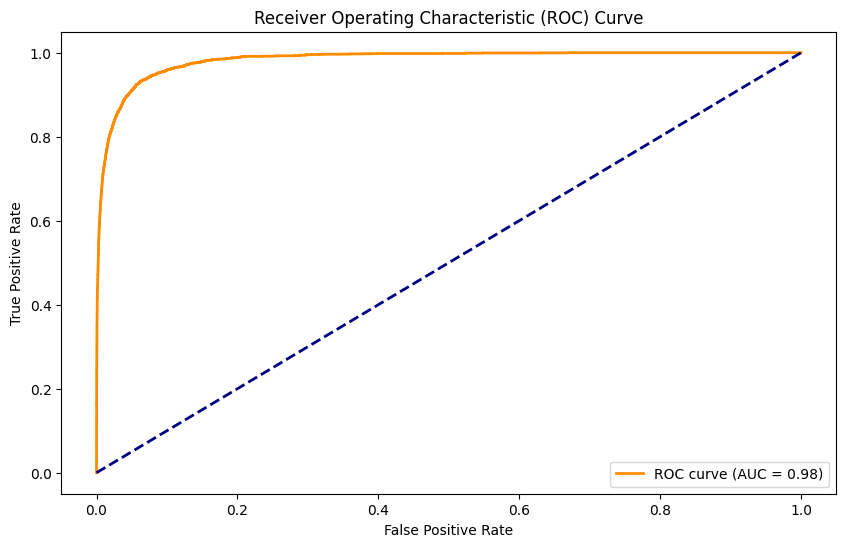

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [53]:
tqdm.pandas(desc="Processing comments", position=0, leave=True)
test['comment_text'] = test['comment_text'].progress_apply(processing)

Processing comments: 100%|██████████| 153164/153164 [01:58<00:00, 1295.52it/s]


In [54]:
testData = tokenizer.texts_to_sequences(test['comment_text'])
testData = pad_sequences(testData, padding=pad_type, maxlen=maxlen)
pred     = lstm.predict(testData)

4787/4787 [==============================] - 95s 20ms/step


In [55]:
predictions = pd.DataFrame(pred, columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submit      = pd.concat((test['id'], predictions), axis = 1)
submit.to_csv("submission_biLSTM_dropout.csv", index= False)

In [56]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         20800384  
                                                                 
 bidirectional (Bidirection  (None, None, 256)         263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         164352    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                        

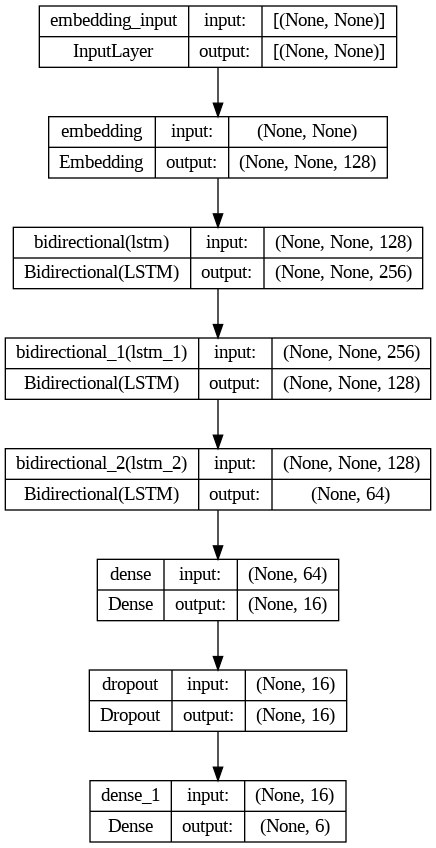

In [58]:
tf.keras.utils.plot_model(lstm, show_shapes=True)

In [57]:
with open('model.pkl', 'wb') as file:
    pickle.dump(lstm, file)

In [ ]:
lstm.save("model_TEST.h5")